In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f14d2ad96e8357be5034c52ffa401e758ed2a93e129c595c690d72a1ea947743
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.4 MB/s eta 0:00:00


In [3]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
import lightgbm
import xgboost as xgb
import ngboost
import catboost

from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix


from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/model/4.11_obj_modi.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,fico_range_mean,target
0,1,680.82,126.0,277.0,0.0,0.0,110000.0,34.70,23200.000000,3,24.99,23200.0,2.0,0.0,2016,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,672.0,1
1,3,494.55,134.0,400.0,0.0,0.0,65000.0,17.74,16000.000000,7,7.07,16000.0,3.0,0.0,2017,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,822.0,1
2,4,146.10,226.0,130.0,2.0,2.0,50000.0,6.99,4500.000000,6,10.42,4500.0,1.0,0.0,2017,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,702.0,0
3,5,645.25,149.0,190.0,0.0,0.0,60000.0,28.94,20000.000000,6,9.99,20000.0,1.0,5.0,2015,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,677.0,0
4,6,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,737.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071205,1534129,662.45,232.0,144.0,0.0,0.0,60000.0,20.02,26450.000000,5,17.27,26500.0,1.0,0.0,2013,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,697.0,0
1071206,1534131,133.78,151.0,36.0,0.0,0.0,33800.0,19.18,3600.000000,3,19.99,3600.0,1.0,0.0,2014,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,667.0,1
1071207,1534132,583.89,125.0,216.0,0.0,0.0,71000.0,23.92,18875.000000,7,6.68,19000.0,5.0,0.0,2015,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,737.0,0
1071208,1534133,329.65,25.0,99.0,0.0,0.0,44000.0,12.85,9600.000000,5,14.33,9600.0,1.0,0.0,2013,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,692.0,0


In [5]:
# 결측치 있나 확인
df.isnull().sum()

Unnamed: 0                    0
installment                   0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
pub_rec                       0
pub_rec_bankruptcies          0
annual_inc                    0
dti                           0
funded_amnt_inv               0
grade                         0
int_rate                      0
loan_amnt                     0
mort_acc                      0
num_accts_ever_120_pd         0
issue_d_year                  0
issue_d_month                 0
home_ownership_MORTGAGE       0
home_ownership_NONE           0
home_ownership_OTHER          0
home_ownership_OWN            0
home_ownership_RENT           0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_house                 0
purpose_major_purchase        0
purpose_medical               0
purpose_moving                0
purpose_other                 0
purpose_renewable_energy      0
purpose_

In [6]:
# 필요 없는 부분 제거
df.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
df

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,fico_range_mean,target
0,680.82,126.0,277.0,0.0,0.0,110000.0,34.70,23200.000000,3,24.99,23200.0,2.0,0.0,2016,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,672.0,1
1,494.55,134.0,400.0,0.0,0.0,65000.0,17.74,16000.000000,7,7.07,16000.0,3.0,0.0,2017,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,822.0,1
2,146.10,226.0,130.0,2.0,2.0,50000.0,6.99,4500.000000,6,10.42,4500.0,1.0,0.0,2017,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,702.0,0
3,645.25,149.0,190.0,0.0,0.0,60000.0,28.94,20000.000000,6,9.99,20000.0,1.0,5.0,2015,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,677.0,0
4,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,737.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071205,662.45,232.0,144.0,0.0,0.0,60000.0,20.02,26450.000000,5,17.27,26500.0,1.0,0.0,2013,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,697.0,0
1071206,133.78,151.0,36.0,0.0,0.0,33800.0,19.18,3600.000000,3,19.99,3600.0,1.0,0.0,2014,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,667.0,1
1071207,583.89,125.0,216.0,0.0,0.0,71000.0,23.92,18875.000000,7,6.68,19000.0,5.0,0.0,2015,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,737.0,0
1071208,329.65,25.0,99.0,0.0,0.0,44000.0,12.85,9600.000000,5,14.33,9600.0,1.0,0.0,2013,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,692.0,0


In [8]:
x_data = list(df.columns)
x_data.remove('target')

In [10]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_new, y_new = smt.fit_resample(df[x_data], df['target'])

In [16]:
print(X_new.shape)
print(y_new.shape)

(1720890, 85)
(1720890,)


In [18]:
# 우선 랜덤하게 data_split하고 돌려봄 8:2
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [19]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(f1_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [21]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5, num_leaves = 50), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
#ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:23

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 688165, number of negative: 688547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3489
[LightGBM] [Info] Number of data points in the train set: 1376712, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499861 -> initscore=-0.000555
[LightGBM] [Info] Start training from score -0.000555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [23]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat)
    #('NgBoost', ngb),
]

In [ ]:
# model = [xgboost, lgb, cat]
# threshold = np.linspace(25, 75,51)/100

In [ ]:
# threshold

array([0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35,
       0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46,
       0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57,
       0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68,
       0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75])

In [ ]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = xgboost.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"xgboost{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

Confusion Matrix for xgboost0.25
[[133074  39149]
 [ 20325  21694]]

Confusion Matrix for xgboost0.26
[[136265  35958]
 [ 21390  20629]]

Confusion Matrix for xgboost0.27
[[139221  33002]
 [ 22463  19556]]

Confusion Matrix for xgboost0.28
[[141943  30280]
 [ 23479  18540]]

Confusion Matrix for xgboost0.29
[[144496  27727]
 [ 24482  17537]]

Confusion Matrix for xgboost0.3
[[146975  25248]
 [ 25507  16512]]

Confusion Matrix for xgboost0.31
[[149201  23022]
 [ 26447  15572]]

Confusion Matrix for xgboost0.32
[[151242  20981]
 [ 27302  14717]]

Confusion Matrix for xgboost0.33
[[153073  19150]
 [ 28173  13846]]

Confusion Matrix for xgboost0.34
[[154816  17407]
 [ 29065  12954]]

Confusion Matrix for xgboost0.35
[[156410  15813]
 [ 29934  12085]]

Confusion Matrix for xgboost0.36
[[157928  14295]
 [ 30735  11284]]

Confusion Matrix for xgboost0.37
[[159305  12918]
 [ 31452  10567]]

Confusion Matrix for xgboost0.38
[[160619  11604]
 [ 32258   9761]]

Confusion Matrix for xgboost0.39
[[

In [ ]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = lgb.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"lgb{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

Confusion Matrix for lgb0.25
[[133864  38359]
 [ 20721  21298]]

Confusion Matrix for lgb0.26
[[137268  34955]
 [ 21935  20084]]

Confusion Matrix for lgb0.27
[[140407  31816]
 [ 23091  18928]]

Confusion Matrix for lgb0.28
[[143325  28898]
 [ 24218  17801]]

Confusion Matrix for lgb0.29
[[146047  26176]
 [ 25244  16775]]

Confusion Matrix for lgb0.3
[[148506  23717]
 [ 26281  15738]]

Confusion Matrix for lgb0.31
[[150813  21410]
 [ 27245  14774]]

Confusion Matrix for lgb0.32
[[152821  19402]
 [ 28218  13801]]

Confusion Matrix for lgb0.33
[[154767  17456]
 [ 29174  12845]]

Confusion Matrix for lgb0.34
[[156542  15681]
 [ 30107  11912]]

Confusion Matrix for lgb0.35
[[158132  14091]
 [ 30985  11034]]

Confusion Matrix for lgb0.36
[[159706  12517]
 [ 31867  10152]]

Confusion Matrix for lgb0.37
[[161182  11041]
 [ 32653   9366]]

Confusion Matrix for lgb0.38
[[162504   9719]
 [ 33452   8567]]

Confusion Matrix for lgb0.39
[[163648   8575]
 [ 34187   7832]]

Confusion Matrix for lgb0.

In [ ]:
# # 테스트셋에 대한 예측 확률 가져오기
# y_pred_proba = cat.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# # 사용자가 정의한 임계값으로 예측을 바꾸기
# confusion_matrices = {}

# for cut in threshold:
#     y_pred = (y_pred_proba >= cut).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     # 딕셔너리에 저장
#     confusion_matrices[f"cat{cut}"] = cm

# for name, cm in confusion_matrices. items():
#     print(f"Confusion Matrix for {name}")
#     print (cm)
#     print()

Confusion Matrix for cat0.25
[[132986  39237]
 [ 20094  21925]]

Confusion Matrix for cat0.26
[[136282  35941]
 [ 21295  20724]]

Confusion Matrix for cat0.27
[[139293  32930]
 [ 22401  19618]]

Confusion Matrix for cat0.28
[[142115  30108]
 [ 23433  18586]]

Confusion Matrix for cat0.29
[[144739  27484]
 [ 24526  17493]]

Confusion Matrix for cat0.3
[[147239  24984]
 [ 25560  16459]]

Confusion Matrix for cat0.31
[[149503  22720]
 [ 26483  15536]]

Confusion Matrix for cat0.32
[[151563  20660]
 [ 27409  14610]]

Confusion Matrix for cat0.33
[[153522  18701]
 [ 28304  13715]]

Confusion Matrix for cat0.34
[[155272  16951]
 [ 29263  12756]]

Confusion Matrix for cat0.35
[[156878  15345]
 [ 30135  11884]]

Confusion Matrix for cat0.36
[[158391  13832]
 [ 30942  11077]]

Confusion Matrix for cat0.37
[[159763  12460]
 [ 31705  10314]]

Confusion Matrix for cat0.38
[[161078  11145]
 [ 32394   9625]]

Confusion Matrix for cat0.39
[[162231   9992]
 [ 33102   8917]]

Confusion Matrix for cat0.

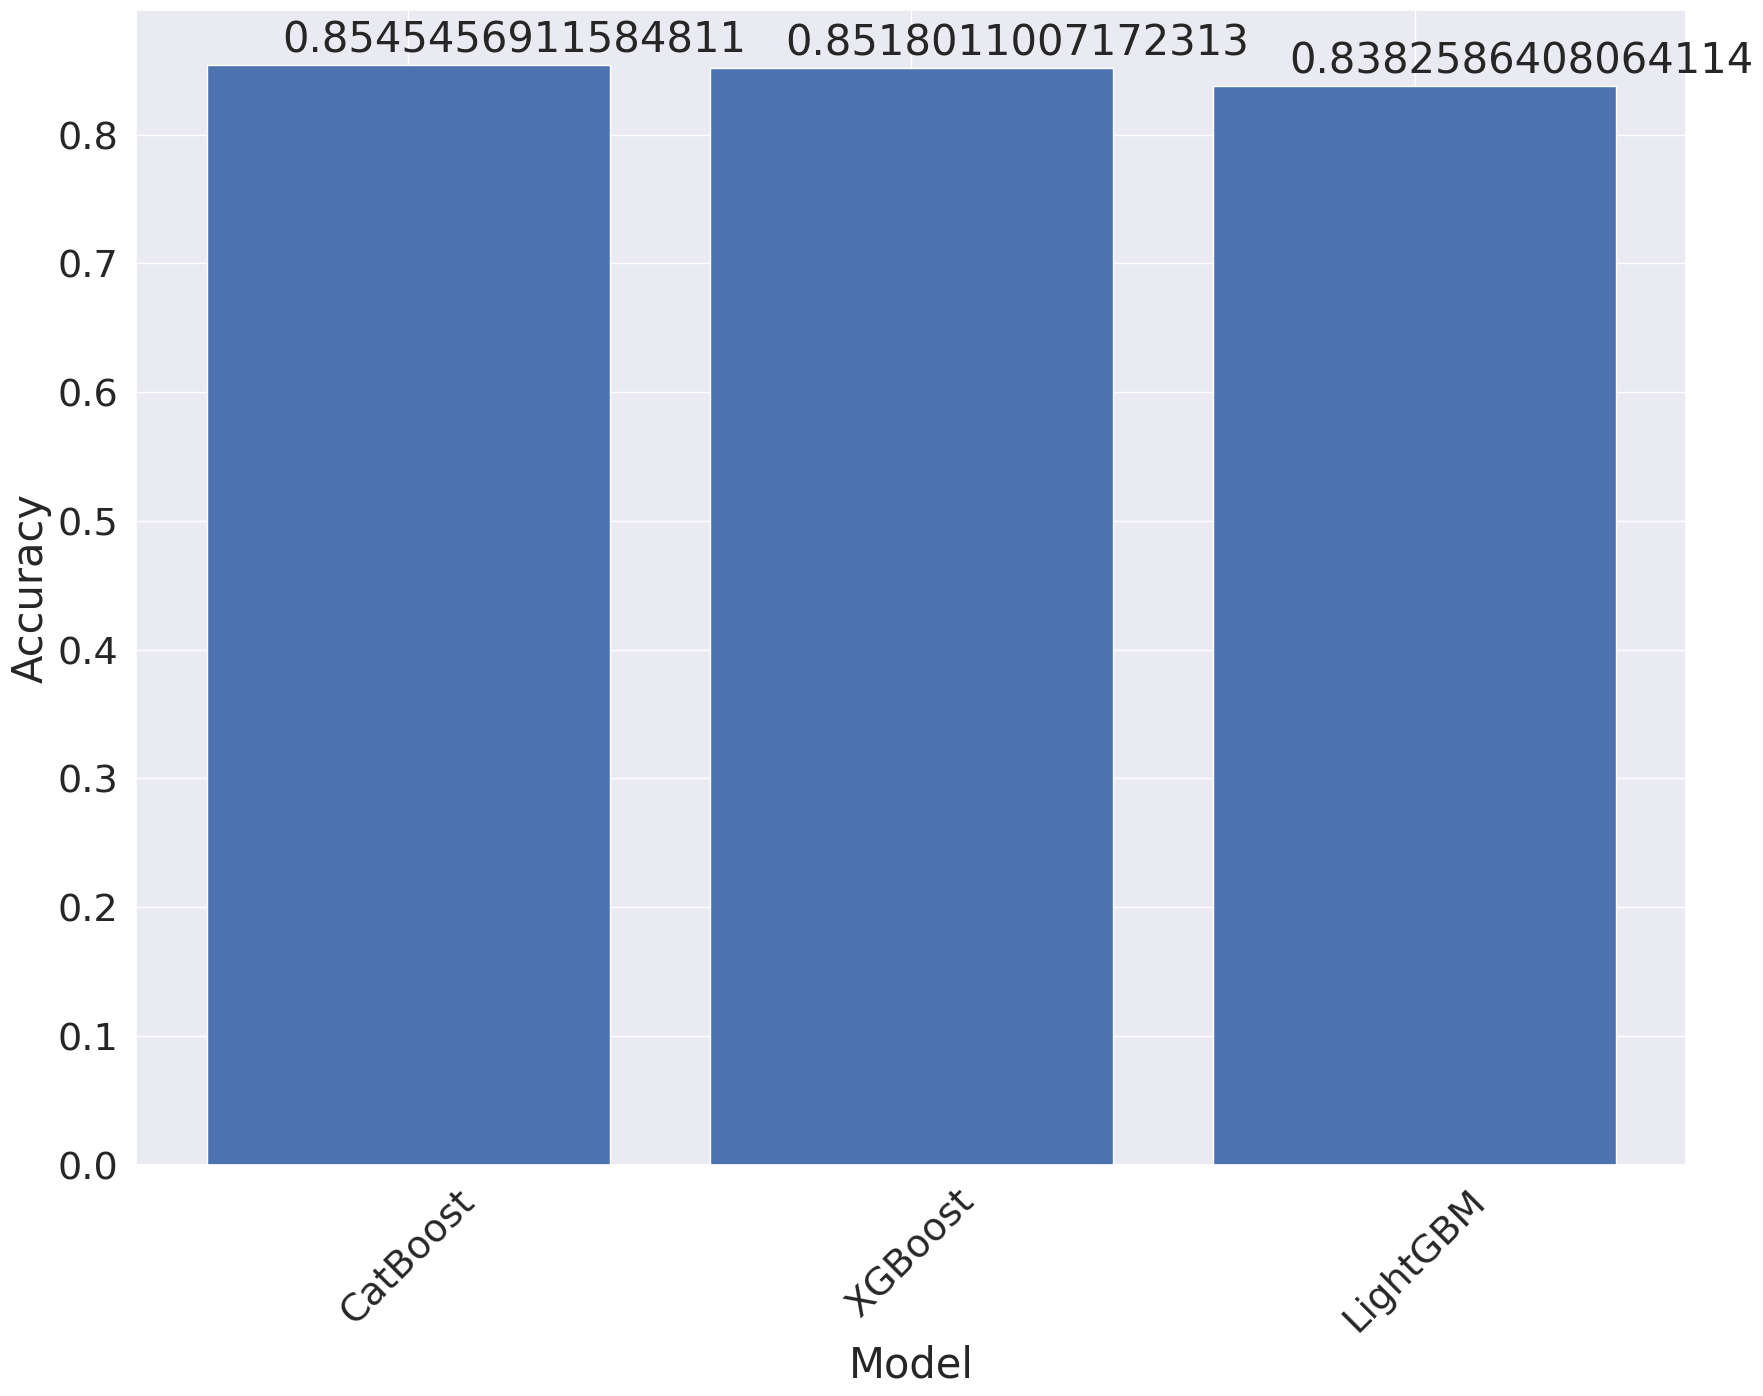

In [24]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'F1': scores })
model_scores.sort_values(by='F1',ascending=False,inplace=True)
plot_metric(model_scores, score='F1')

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgboost.predict(X_test)))


              precision    recall  f1-score   support

           0       0.81      0.96      0.88    171898
           1       0.95      0.77      0.85    172280

    accuracy                           0.87    344178
   macro avg       0.88      0.87      0.86    344178
weighted avg       0.88      0.87      0.86    344178



In [ ]:
# test 데이터 predict 구하기
# xgb
#xgboost.predict(df_test[x_data])
# lgb
#lgb.predict(df_test[x_data])
# cat
cat.predict(df_test[x_data])

array([0, 1, 1, ..., 0, 0, 1])

## Confusion matrix

In [26]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[165280   6618]
 [ 39563 132717]]

Confusion Matrix for LightGBM
[[161967   9931]
 [ 40805 131475]]

Confusion Matrix for CatBoost
[[168140   3758]
 [ 40950 131330]]



각 연도별 데이터를 dict형태로 정리해서 각각 예측한 값을 confusion으로 비교

In [ ]:
year = list(df['issue_d_year'].unique())

In [ ]:
year

[2016,
 2017,
 2015,
 2019,
 2018,
 2014,
 2013,
 2020,
 2012,
 2008,
 2011,
 2010,
 2009,
 2007]

In [ ]:
year_dict = {}
for x in year:
    year_dict[x] = df[df['issue_d_year'] == x]


In [ ]:
year_dict[2019].drop('target', axis = 1)

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,fico_range_high,fico_range_low,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
4,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,739.0,735.0,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,306.64,133.0,286.0,0.0,0.0,150000.0,23.00,699.0,695.0,12475.000000,5,16.40,12500.0,1.0,0.0,2019,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,443.49,160.0,515.0,0.0,0.0,48000.0,15.33,664.0,660.0,12750.000000,5,15.24,12750.0,0.0,3.0,2019,12,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,1256.97,60.0,77.0,1.0,1.0,140000.0,6.91,684.0,680.0,40000.000000,7,8.19,40000.0,2.0,0.0,2019,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,240.27,238.0,164.0,0.0,0.0,46000.0,22.83,764.0,760.0,7000.000000,5,14.30,7000.0,0.0,0.0,2019,9,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071121,277.84,154.0,103.0,1.0,1.0,120000.0,10.15,694.0,690.0,8400.000000,6,11.71,8400.0,0.0,1.0,2019,10,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1071158,425.73,72.0,71.0,1.0,1.0,82000.0,15.76,669.0,665.0,13000.000000,6,11.02,13000.0,2.0,0.0,2019,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071170,1256.97,121.0,201.0,0.0,0.0,85000.0,4.86,709.0,705.0,40000.000000,7,8.19,40000.0,5.0,0.0,2019,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1071179,648.40,83.0,85.0,1.0,1.0,57000.0,19.18,694.0,690.0,17950.000000,5,17.74,18000.0,0.0,0.0,2019,7,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(year_dict[2007].drop('target', axis = 1))
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(year_dict[2007]['target'], y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]



In [ ]:
for year in range(2007,2021):
    confusion_matrices = {}
    # 각 모델에 대한 전퓨전 매트릭스 상성
    for name, model in models:
        # 모델의 예측값 얻기
        y_pred = model.predict(year_dict[year].drop('target', axis = 1))
        # 컨퓨전 매트릭스 생성
        cm = confusion_matrix(year_dict[year]['target'], y_pred)
        # 딕셔너리에 저장
        confusion_matrices[name] = cm

    # 컨퓨전 매트릭스 출력
    for name, cm in confusion_matrices. items():
        print(f"{year} Confusion Matrix for {name}")
        print (cm)
        print()

2007 Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

2007 Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

2007 Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]

2008 Confusion Matrix for XGBoost
[[1123    2]
 [ 288    3]]

2008 Confusion Matrix for LightGBM
[[1125    0]
 [ 291    0]]

2008 Confusion Matrix for CatBoost
[[1125    0]
 [ 291    0]]

2009 Confusion Matrix for XGBoost
[[2634    0]
 [ 415    3]]

2009 Confusion Matrix for LightGBM
[[2634    0]
 [ 418    0]]

2009 Confusion Matrix for CatBoost
[[2634    0]
 [ 418    0]]

2010 Confusion Matrix for XGBoost
[[6124    5]
 [ 971    4]]

2010 Confusion Matrix for LightGBM
[[6129    0]
 [ 974    1]]

2010 Confusion Matrix for CatBoost
[[6127    2]
 [ 973    2]]

2011 Confusion Matrix for XGBoost
[[10444    10]
 [ 1815    22]]

2011 Confusion Matrix for LightGBM
[[10453     1]
 [ 1835     2]]

2011 Confusion Matrix for CatBoost
[[10451     3]
 [ 1829     8]]

2012 Confusion Matrix for XGBoost
[[26544    25]
 [ 5136    

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)